# Assignment set 1: The 1D wave equation and 2D diffusion equation

#### Job Marcelis, Ernani Hazbolatow, Koen Verlaan

To show all the results, we import the required functions from the modules in the `src` folder.

In [28]:
from src.exercise1_1 import animate_wave, plotting_snapshots, calculate_wave
from src.exercise1_2 import analytical_vs_experimental, plot_heatmap, animate_diffusion
from src.exercise1_6 import *
from IPython.display import HTML
import matplotlib.pyplot as plt

plt.rcParams['animation.embed_limit'] = 50

#### Exercise 1.1

In exercise 1.1, we discretize the 1D wave equation using the central difference method. Three different initial conditions are considered: 
- $\Psi(x, t=0) = sin(2\pi x)$
- $\Psi(x, t=0) = sin(5\pi x)$
- $\Psi(x, t=0) = sin(5\pi x)$ if $1/5 < x < 2/5$, else $\Psi = 0$.

These correspond to `wave_data1`, `wave_data2`, and `wave_data3`, respectively. 

To visualise the wave equation, the parameters `L` (length of the string) and `c` (wave speed) can be chosen. We then simulate the vibrating string for multiple initial conditions for a set number of time steps.

In [2]:
L = 1
c = 1
N = 1000
dt = 0.001
timesteps = 1100
snapshot_arr = [0, 250, 500, 750, 1000]
wave_data1, x = calculate_wave(L, c, N, dt, timesteps, 1)
wave_data2, x = calculate_wave(L, c, N, dt, timesteps, 2)
wave_data3, x = calculate_wave(L, c, N, dt, timesteps, 3)

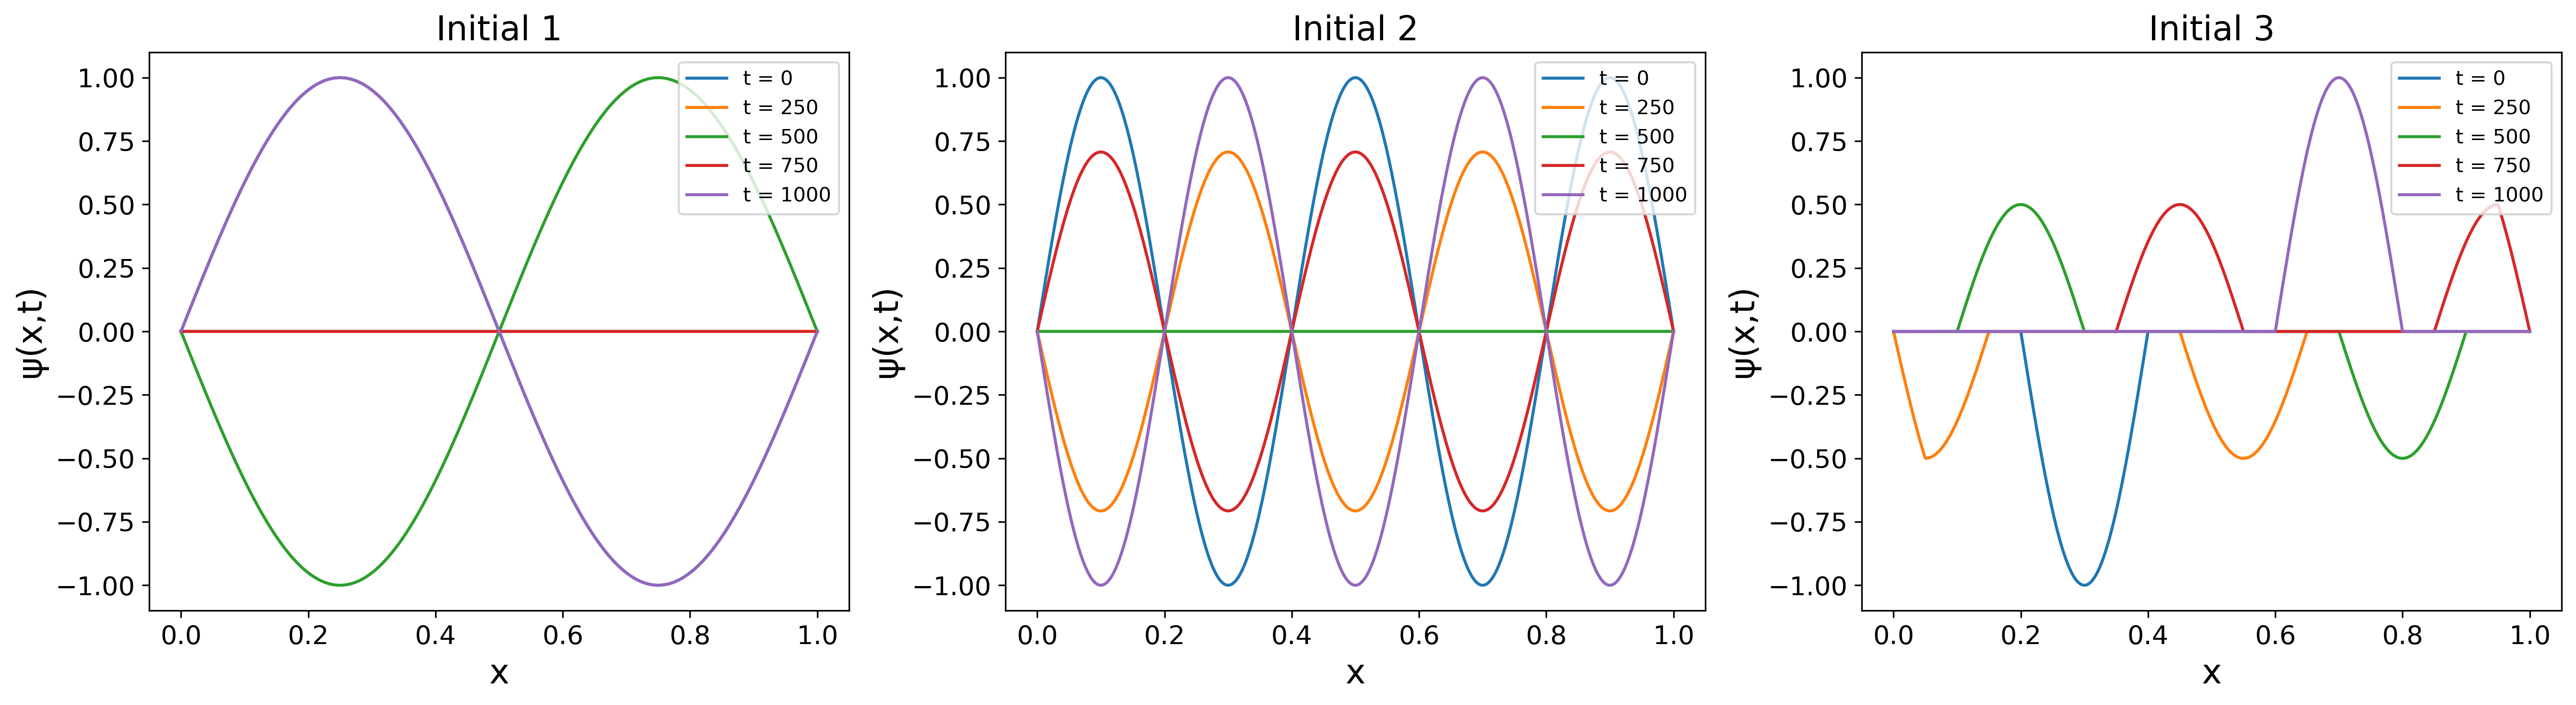

In [3]:
plotting_snapshots([wave_data1, wave_data2, wave_data3], ["Initial 1", "Initial 2", "Initial 3"], x, snapshot_arr, figsize=None)

An animation is made to show the time evolution of the vibrating string more clearly. The different initial conditions can be visualised by changing the first parameter of the function `animate_wave`. 

In [ ]:
ani = animate_wave(wave_data1, x, timesteps)
HTML(ani.to_jshtml())

#### Exercise 1.2

In the next exercise, we model the 2D diffusion equation of a concentration on a square grid: $0 \leq x, y \leq 1$. Furthermore, we have fixed boundary conditions on the top and bottom:
- $c(x, y = 1;t) = 1$
- $c(x, y = 0;t) = 0$

And periodic boundary conditions in de x-direction:
- $c(x = 0, y;t) = c(x = 1, y;t)$

We use a 5-point stencil to update all the values.

In [4]:
N = 150
dt = 0.00001
dx = 1/N
D = 1
test_times = [0, 0.001, 0.01, 0.1, 1]
num_frames = 100

if 4*dt*D/(dx**2) <= 1:
    print(f'Stable: {4*dt*D/(dx**2)}')
else:
    raise ValueError(f'Not stable ({4*dt*D/(dx**2)}), reduce dt')

Stable: 0.8999999999999999


To test our simulation, we compared our model to the analytical solution for the concentration along the y-axis at the following times: $t = \{0, 0.001, 0.01, 0.1, 1\}$

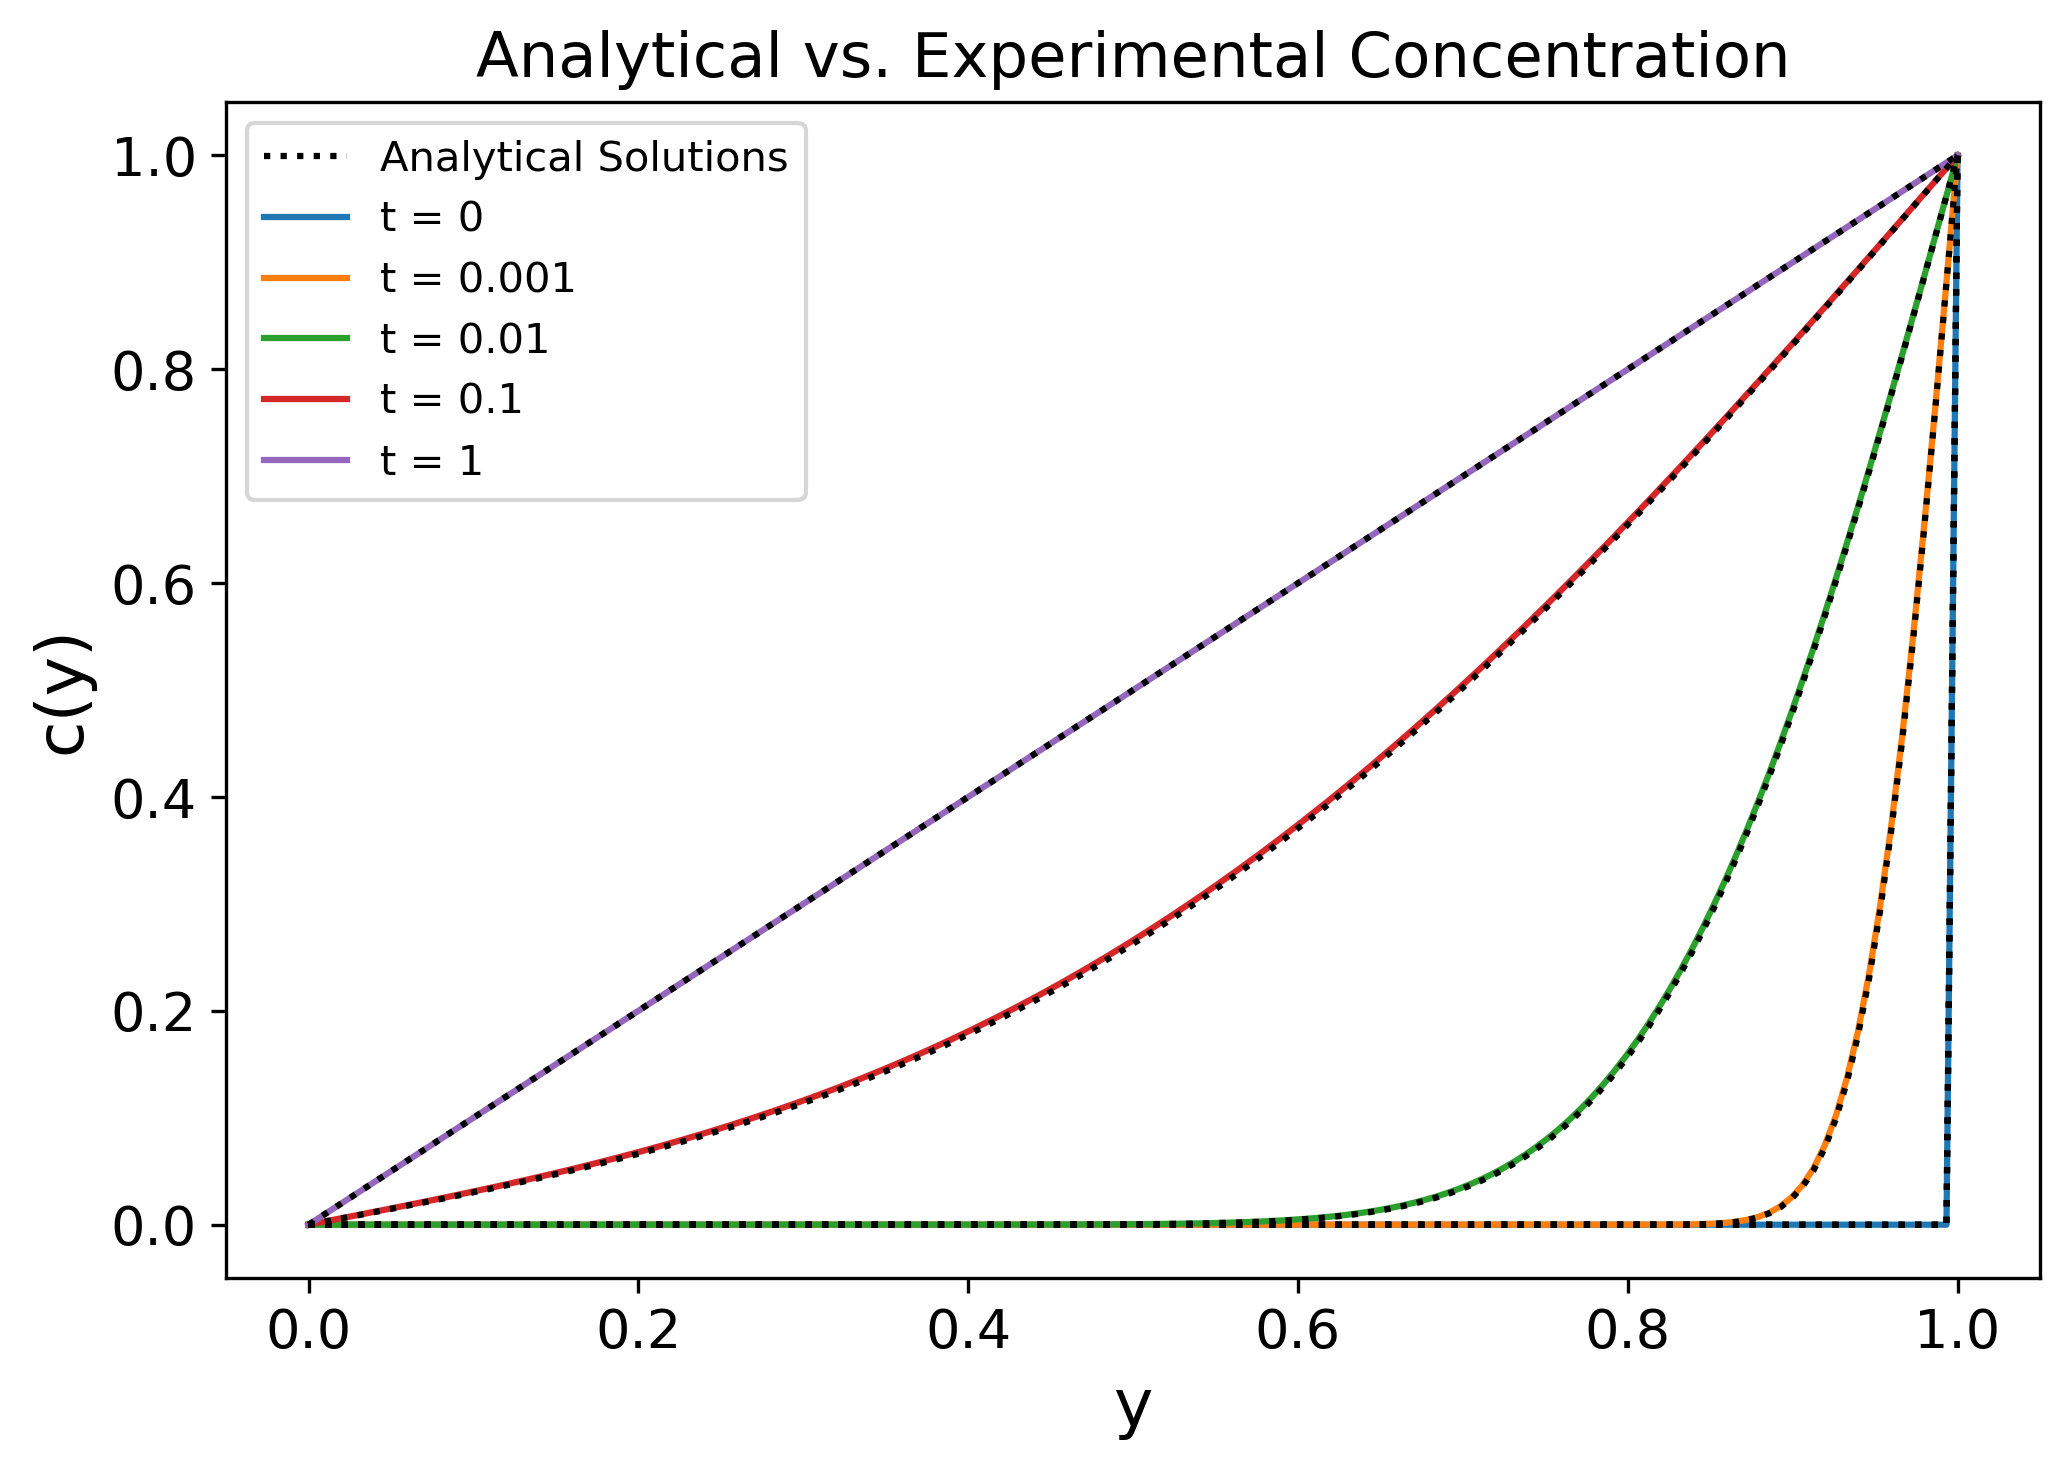

In [5]:
analytical_vs_experimental(test_times, N, dt, dx, D)

To show what happens in the 2D domain, we make a heatmap at different times:

In [27]:
plot_heatmap([0, 0.01, 1], N, dt, dx, D)

TypeError: object of type 'int' has no len()

A more detailed diffusion is shown with an animation:

In [ ]:
ani = animate_diffusion(num_frames, N, dt, dx, D)
HTML(ani.to_jshtml())

#### Exercise 1.3-1.6

We now continue with the time-independent diffusion equation. Three different iterative methods are compared: `Jacobi Iteration`, `Gauss-Seidel Iteration`, and `Successive Over Relaxation (SOR)`. We investigate the accuracy of the solution and the number of iterations to reach convergence for each method. In addition, the optimal value for $\omega$ for the SOR method is calculated.

Finally, we introduce an increasing number of objects into the computational domain, which act as concentration sinks. This means that the value of the concentration is 0. We then investigate the impact it has on the number of iterations and the optimal omega.

In [ ]:
N = 150
eps = 1e-5
max_iter = int(2e4)
omegas = np.linspace(1.7, 2, 100)
Ns = np.linspace(10, 200, 20)

# These are the boundaries for the objects
# per row: i_min, i_max, j_min, j_max

########### Squares near the top of domain #############
one_square = np.array([[18, 24, 47, 53]])*N/100

two_square = np.array([[18, 24, 30, 36],
                       [18, 24, 63, 69]])*N/100

three_square = np.array([[18, 24, 22, 28],
                         [18, 24, 47, 53],
                         [18, 24, 72, 78]])*N/100

############ Squares near the bottom of domain #############
# one_square = np.array([[80, 86, 47, 53]])*N/100

# two_square = np.array([[80, 86, 30, 36],
#                        [80, 86, 63, 69]])*N/100

# three_square = np.array([[80, 86, 22, 28],
#                          [80, 86, 47, 53],
#                          [80, 86, 72, 78]])*N/100

Compare the linear behaviour of the concentration for multiple iterative schemes. For the SOR method, the optimal omega for the corresponding grid size is used (which is plotted later on).

In [ ]:
compare_methods_to_analytical(N, 1.97, eps, max_iter)

The convergence is measured using the maximum difference between the last two iterations. This is then plotted versus the number of iterations for different numerical methods (and different values of omega for SOR).

In [ ]:
convergence_measure(N, [1.75, 1.85, 1.95], eps, max_iter)

We now search for the optimal omega for the SOR method and investigate how it changes with N

In [ ]:
omegas = optimal_omega(Ns, omegas, eps, max_iter)

To obtain exact values, we print the results below:

In [ ]:
for i in range(len(Ns)):
    print(f'Optimal omega at N = {int(Ns[i])} is {round(omegas[i], 2)}')

Next, the convergence versus the number of iterations for a different number of squares in the grid calculated, $N=150$, $\omega=1.97$

In [ ]:
convergence_with_objects([one_square, two_square, three_square], N, 1.97, eps, max_iter)

To understand the effect of introducing objects into the computational domain, we calculate the optimal $\omega$ for a different number of concentration sinks. 

In [ ]:
opt_omega = optimal_omega([150], omegas, eps, max_iter, plot=False)
print(f'The optimal omega without squares is {opt_omega[0]}')
optimal_omega_with_objects([one_square, two_square, three_square], N, omegas, eps, max_iter)

Finally, we plot the 2D domain with the objects when convergence is reached.

In [ ]:
final_grid_1sq, _, _ = SOR_object(init_objects(one_square, N), N, 1.97, eps, max_iter)
final_grid_2sq, _, _ = SOR_object(init_objects(two_square, N), N, 1.97, eps, max_iter)
final_grid_3sq, _, _ = SOR_object(init_objects(three_square, N), N, 1.97, eps, max_iter)

plt.figure(figsize=(18, 5), dpi=300)

plt.subplot(1, 3, 1)
plt.imshow(final_grid_1sq, extent=[0, 1, 0, 1])
plt.xlabel('x', fontsize=17)
plt.ylabel('y', fontsize=17)
plt.title(f'Diffusion with 1 Concentration Sink', fontsize=16) 
plt.tick_params(axis="both", labelsize = 13)
cbar = plt.colorbar(label='Concentration')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Concentration', fontsize=16)

plt.subplot(1, 3, 2)
plt.imshow(final_grid_2sq, extent=[0, 1, 0, 1])
plt.xlabel('x', fontsize=17)
plt.title(f'Diffusion with 2 Concentration Sinks', fontsize=16)
plt.tick_params(axis="both", labelsize = 13)
cbar = plt.colorbar(label='Concentration')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Concentration', fontsize=16)

plt.subplot(1, 3, 3)
plt.imshow(final_grid_3sq, extent=[0, 1, 0, 1])
plt.xlabel('x', fontsize=16)
plt.title(f'Diffusion with 3 Concentration Sinks', fontsize=16)
plt.tick_params(axis="both", labelsize = 13)
cbar = plt.colorbar(label='Concentration')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Concentration', fontsize=16)

plt.tight_layout()
plt.show()